# Image Segmentation using DeeplabV3 Torchvision

By [Akshaj Verma](https://akshajverma.com)


This notebook takes you through an implementation of using a pretrained deeplabv3 torchvision model on the [Chest X-Ray dataset](https://www.kaggle.com/ianmoone0617/chest-x-ray-image-segmentation-with-lungs-mask).

In [1]:
import pathlib
from tqdm.notebook import tqdm

import cv2
from PIL import Image

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler


from sklearn.metrics import jaccard_score
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
np.random.seed(0)
torch.manual_seed(0)

In [3]:
%matplotlib inline
sns.set_style('darkgrid')

## Define Paths and Set GPU

Let's define the path for our data.

In [4]:
ROOT_PATH = "../../../data/computer_vision/image_segmentation/chest-x-ray/"
images_path = ROOT_PATH + "images/"
labels_path = ROOT_PATH + "masks"

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print("We're using =>", device)

We're using => cuda


## Visualize Data

### Training image

Shape of the image is:  (512, 512, 3) 




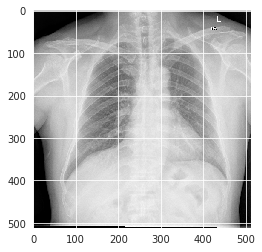

In [6]:
img = Image.open(images_path + "CHNCXR_0001_0.png")
print("Shape of the image is: ", np.array(img).shape, "\n\n")
plt.imshow(img)

### Histogram of image

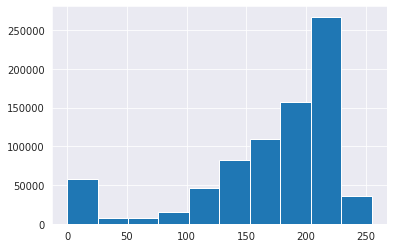

In [7]:
plt.hist(np.array(img).flatten())
plt.show()

### Training label

Shape of the label is:  (224, 224) 




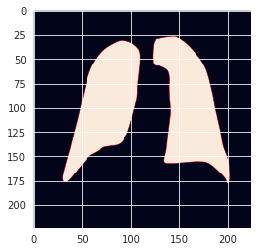

In [8]:
lbl = Image.open(labels_path + "/CHNCXR_0001_0_mask.png").convert('L')
lbl = lbl.resize((224, 224))
print("Shape of the label is: ", np.array(lbl).shape, "\n\n")
plt.imshow(lbl)

### Histogram of label

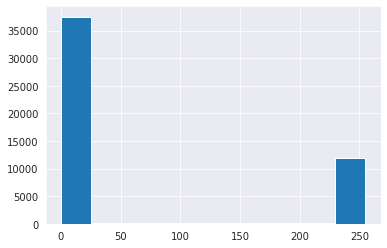

In [9]:
plt.hist(np.array(lbl).flatten())
plt.show()

In [10]:
lbl = np.array(lbl)
lbl[lbl < 255] = 0
lbl[lbl == 255] = 1

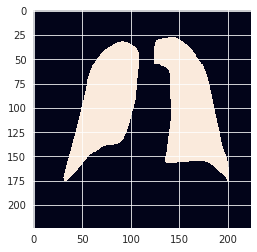

In [11]:
plt.imshow(lbl * 50)

## Data Preprocessing

### Create Transforms

In [12]:
IMAGE_LABEL_SIZE = 224

image_transforms = {
    "train": transforms.Compose([
#         transforms.Resize((IMAGE_LABEL_SIZE, IMAGE_LABEL_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
    ]),
    "test": transforms.Compose([
#         transforms.Resize((IMAGE_LABEL_SIZE, IMAGE_LABEL_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
    ])
}

### Create Dataset

#### Path to data

In [13]:
root_path = pathlib.Path(ROOT_PATH)

print("Root path: ", root_path)
print("")

# train paths
train_images_path = root_path.joinpath("images")
train_labels_path = root_path.joinpath("masks")

print("Train Images path: ", train_images_path)
print("Train Labels path: ", train_labels_path)
print("")

Root path:  ../../../data/computer_vision/image_segmentation/chest-x-ray

Train Images path:  ../../../data/computer_vision/image_segmentation/chest-x-ray/images
Train Labels path:  ../../../data/computer_vision/image_segmentation/chest-x-ray/masks



#### Base Dataset Class

In [14]:
class DatasetChestXray(Dataset):
    def __init__(self, images_path, labels_path, image_transform, img_lbl_size):
        super(DatasetChestXray, self).__init__()
        self.images_path = pathlib.Path(images_path)
        self.labels_path = pathlib.Path(labels_path)
        
        self.img_lbl_size = img_lbl_size
        self.transform = image_transform
        
        self.img_file_paths = [file for file in images_path.rglob("**/*.png")]
        self.lbl_file_paths = [file for file in labels_path.rglob("**/*.png")]
        
    def __getitem__(self, idx):
        img_path = str(self.img_file_paths[idx])
        lbl_path = str(self.lbl_file_paths[idx])
                
        img = Image.open(img_path).resize((IMAGE_LABEL_SIZE, IMAGE_LABEL_SIZE))
        img = self.transform(img)
        
        lbl = Image.open(lbl_path).convert('L').resize((IMAGE_LABEL_SIZE, IMAGE_LABEL_SIZE))
        lbl = np.array(lbl)
        lbl[lbl < 255] = 0
        lbl[lbl == 255] = 1

        lbl = torch.from_numpy(lbl).long()
        
        return img, lbl
    
    def __len__(self):
        assert len(self.img_file_paths) == len(self.lbl_file_paths)
        return len(self.img_file_paths)

#### Train - Val - Test Split

In [15]:
train_test_dataset = DatasetChestXray(images_path=train_images_path, labels_path=train_labels_path, image_transform=image_transforms["train"], img_lbl_size=IMAGE_LABEL_SIZE)

We use `SubsetRandomSampler` to make our train and validation loaders. `SubsetRandomSampler` is used so that our each batch receives a random distribution of classes.

`SubsetRandomSampler(indices)` takes as input the indices of data.

We first create our samplers and then we'll pass it to our dataloaders.

* Create a list of indices.
* Shuffle the indices.
* Split the indices based on train-val percentage.
* Create SubsetRandomSampler.

In [16]:
def create_samplers(dataset, train_percent, val_percent):
    # Create a list of indices from 0 to length of dataset.
    dataset_size = len(dataset)
    dataset_indices = list(range(dataset_size))
    
    # Shuffle the list of indices using `np.shuffle`.
    np.random.shuffle(dataset_indices)
    
    # Create the split index. We choose the split index to be 20% (0.2) of the dataset size.
    train_split_index = int(np.floor(train_percent * dataset_size))
    val_split_index = int(np.floor(val_percent * dataset_size))
    

    # Slice the lists to obtain 2 lists of indices, one for train and other for test.
    # `0-------------------------- train_idx----- val_idx ---------n`

    train_idx = dataset_indices[:train_split_index]
    val_idx = dataset_indices[train_split_index:train_split_index+val_split_index]
    test_idx = dataset_indices[train_split_index+val_split_index:]
    
    # Finally, create samplers.
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    
    return train_sampler, val_sampler, test_sampler

In [17]:
train_sampler, val_sampler, test_sampler = create_samplers(train_test_dataset, 0.8, 0.1)

### Create Dataloaders

In [18]:
train_loader = DataLoader(dataset=train_test_dataset, shuffle=False, batch_size=8, sampler = train_sampler)
val_loader = DataLoader(dataset=train_test_dataset, shuffle=False, batch_size=1, sampler = val_sampler)
test_loader = DataLoader(dataset=train_test_dataset, shuffle=False, batch_size=1, sampler = test_sampler)

### Data Sanity Check

In [19]:
print("Shape of image from train-loader = ", next(iter(train_loader))[0].shape)
print("Shape of label from train-loader = ", next(iter(train_loader))[1].shape)

print("\nShape of image from val-loader = ", next(iter(val_loader))[0].shape)
print("Shape of label from val-loader = ", next(iter(val_loader))[1].shape)

print("\nShape of image from test-loader = ", next(iter(test_loader))[0].shape)
print("Shape of label from test-loader = ", next(iter(test_loader))[1].shape)

Shape of image from train-loader =  torch.Size([8, 3, 224, 224])
Shape of label from train-loader =  torch.Size([8, 224, 224])

Shape of image from val-loader =  torch.Size([1, 3, 224, 224])
Shape of label from val-loader =  torch.Size([1, 224, 224])

Shape of image from test-loader =  torch.Size([1, 3, 224, 224])
Shape of label from test-loader =  torch.Size([1, 224, 224])


## DeeplabV3 Model

In [20]:
model = models.segmentation.deeplabv3_resnet101(pretrained=True, progress=True)

In [ ]:
# model

In [50]:
model.classifier[4] = nn.Conv2d(in_channels=256, out_channels=2, kernel_size=1, stride=1)

In [51]:
model.to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [52]:
loss_stats = {
    'train': [],
    "val": []
}

In [53]:
EPOCHS = 2

In [ ]:
print("Begin training.")

for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
               
        train_loss = criterion(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        
        
    # VALIDATION
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                                    
            val_loss = criterion(y_val_pred, y_val_batch)
            
            val_epoch_loss += train_loss.item()

    
    if e%20 == 0:
        model_name = "model_idd_seg_fcn8_" + str(e)
        torch.save(model, model_name)
        
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
                        
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')

In [7]:
torch.max(torch.unique(torch.randn(1, 3)))

tensor(-0.0981)

In [ ]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        y_test_pred = model(x_batch)
        
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_tag = y_pred_tag
    
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

In [ ]:
total_iou = 0

for i in range(len(y_pred_list)):
    temp_iou = jaccard_score(y_true_list[i].squeeze().flatten(), y_pred_list[i].squeeze().flatten(), average="macro")
    total_iou += temp_iou

In [ ]:
print("Cumulative IOU = ", total_iou/len(y_pred_list))

In [ ]:
def array_to_img_for_viz(arr):
    arr = arr * 41
    arr = arr.squeeze()
    arr = np.uint8(arr)
    arr_img = Image.fromarray(arr)
    
    return arr_img  

In [ ]:
image_index_to_view = 42


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
axes[0].imshow(array_to_img_for_viz(y_true_list[image_index_to_view]))
axes[0].set_title("True Mask")
axes[1].imshow(array_to_img_for_viz(y_pred_list[image_index_to_view]))
axes[1].set_title("Predicted Mask")